In [1]:
import cv2
cv2.samples.addSamplesDataSearchPath(cv2.__path__[0] + "/samples/data")


Task-1:-  Image Stitching, Panorama stitching, Structure from motion, Image Inpainting.

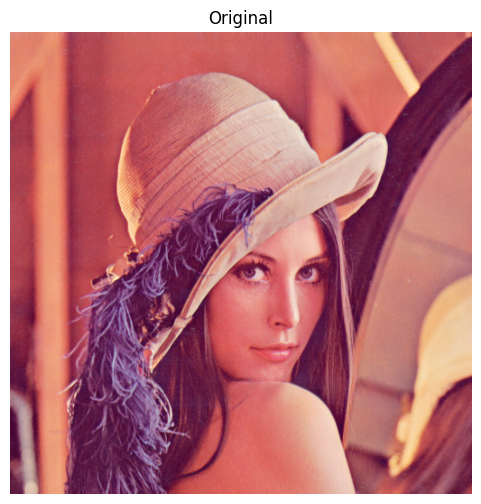

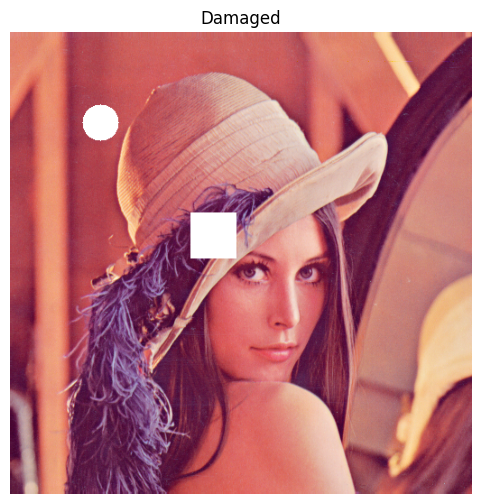

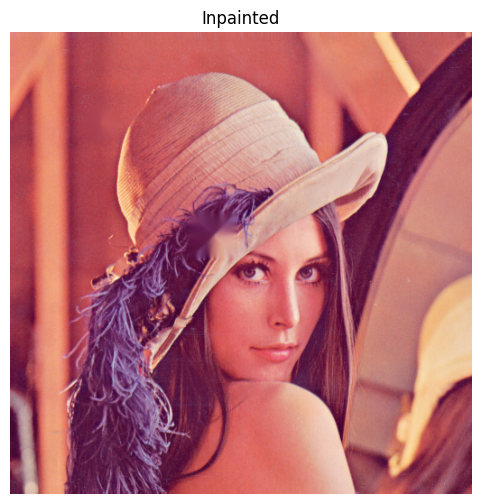

✅ Images loaded successfully.


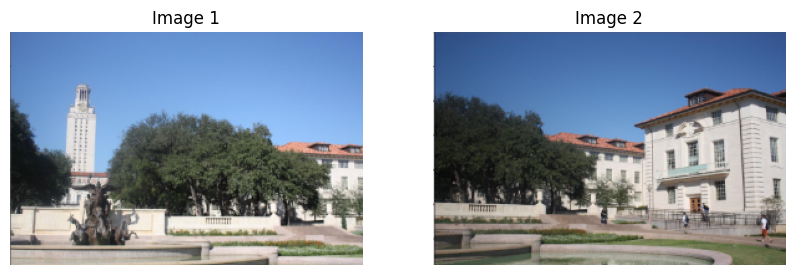

✅ Stitching succeeded.


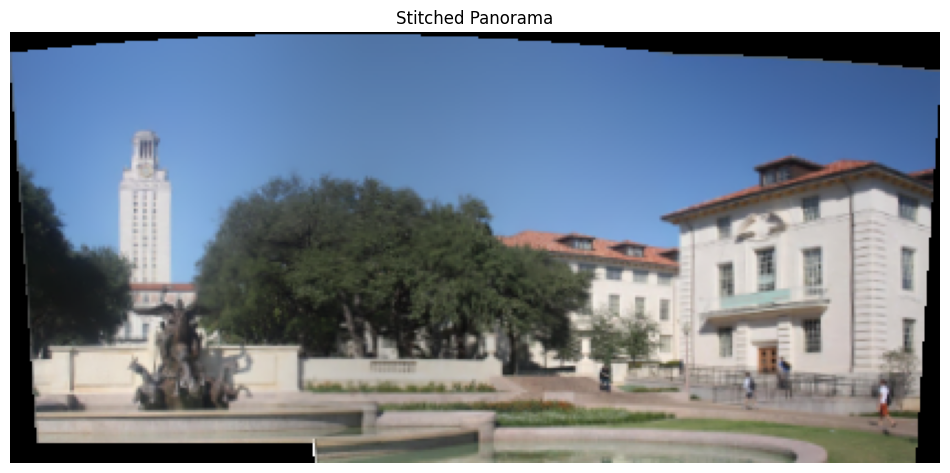

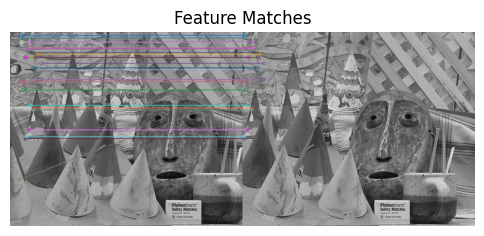

Fundamental Matrix:
 [[-6.78830959e-07 -5.77622659e-04  8.58337811e-02]
 [ 5.64232667e-04 -5.57721811e-05 -8.36101499e-01]
 [-8.25221276e-02  8.34121181e-01  1.00000000e+00]]

Essential Matrix:
 [[-1.12709290e-07 -2.80735448e-04  1.53650656e-02]
 [ 2.65375775e-04 -2.91131096e-05 -7.06939774e-01]
 [-1.42090367e-02  7.06963948e-01 -2.83327716e-05]]


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

# Display helper
def show(title, img, cmap=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Downloader
def download_image(url, filename):
    urllib.request.urlretrieve(url, filename)

# Create image directory
os.makedirs("images", exist_ok=True)

# Working image URLs
images_to_download = {
    "lena.png": "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png",
    "graf1.png": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf1.png",
    "graf3.png": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf3.png",
    "stereo_left.png": "https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im2.png",
    "stereo_right.png": "https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im6.png",
}

# Download all
for name, url in images_to_download.items():
    download_image(url, f"images/{name}")

# Load images
img1 = cv2.imread("images/lena.png")
img_stitch1 = cv2.imread("images/graf1.png")
img_stitch2 = cv2.imread("images/graf3.png")
img_sfm1 = cv2.imread("images/stereo_left.png", cv2.IMREAD_GRAYSCALE)
img_sfm2 = cv2.imread("images/stereo_right.png", cv2.IMREAD_GRAYSCALE)

# Convert BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_stitch1 = cv2.cvtColor(img_stitch1, cv2.COLOR_BGR2RGB)
img_stitch2 = cv2.cvtColor(img_stitch2, cv2.COLOR_BGR2RGB)

# =======================================
# 1. Image Inpainting (Noise Removal)
# =======================================
noisy = img1.copy()
h, w = noisy.shape[:2]
mask = np.zeros((h, w), dtype=np.uint8)

# Add fake noise
cv2.circle(mask, (100, 100), 20, 255, -1)
cv2.rectangle(mask, (200, 200), (250, 250), 255, -1)
noisy[mask == 255] = 255

# Inpaint
inpainted = cv2.inpaint(noisy, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Show results
show("Original", img1)
show("Damaged", noisy)
show("Inpainted", inpainted)

# =======================================
# 2. Panorama Stitching
# =======================================
# Load uploaded images
img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')

# Check if loaded
if img1 is None or img2 is None:
    print("❌ One or both images not loaded. Please upload them manually.")
else:
    print("✅ Images loaded successfully.")

    # Convert to RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Show inputs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')
    plt.show()

    # Stitching
    stitcher = cv2.Stitcher_create()
    status, stitched = stitcher.stitch([img1, img2])

    if status == cv2.Stitcher_OK:
        print("✅ Stitching succeeded.")
        plt.figure(figsize=(12, 6))
        plt.imshow(stitched)
        plt.title("Stitched Panorama")
        plt.axis('off')
        plt.show()
    else:
        print("❌ Stitching failed. Status code:", status)

# =======================================
# 3. Structure from Motion (SfM)
# =======================================
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_sfm1, None)
kp2, des2 = sift.detectAndCompute(img_sfm2, None)

# FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Ratio test
good = [m for m,n in matches if m.distance < 0.7 * n.distance]

# Extract points
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Compute fundamental and essential matrices
F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
E, _ = cv2.findEssentialMat(pts1, pts2)

# Draw feature matches
match_img = cv2.drawMatches(img_sfm1, kp1, img_sfm2, kp2, good[:30], None, flags=2)
show("Feature Matches", match_img, cmap='gray')

print("Fundamental Matrix:\n", F)
print("\nEssential Matrix:\n", E)



Task-2:-  Video Analysis using Python

In [ ]:
import cv2
import numpy as np

# Haar face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Background subtractor
back_sub = cv2.createBackgroundSubtractorMOG2()

def process_frame(frame):
    frame = cv2.resize(frame, (320, 240))  # Resize for faster processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Spatial Domain: Edge Detection
    edges = cv2.Canny(gray, 100, 200)

    # Frequency Domain: FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)
    magnitude_spectrum = magnitude_spectrum.astype(np.uint8)

    # Foreground Detection
    fg_mask = back_sub.apply(frame)

    # Object Detection: Face
    detected_frame = frame.copy()
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        cv2.rectangle(detected_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(detected_frame, "Face", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Convert all to BGR for stacking
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    fg_bgr = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
    fft_bgr = cv2.cvtColor(magnitude_spectrum, cv2.COLOR_GRAY2BGR)

    # Resize all to same size
    detected_frame = cv2.resize(detected_frame, (320, 240))
    edges_bgr = cv2.resize(edges_bgr, (320, 240))
    fg_bgr = cv2.resize(fg_bgr, (320, 240))
    fft_bgr = cv2.resize(fft_bgr, (320, 240))

    # Combine all views
    top_row = np.hstack([detected_frame, edges_bgr])
    bottom_row = np.hstack([fg_bgr, fft_bgr])
    combined = np.vstack([top_row, bottom_row])

    return combined

def main():
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("❌ Cannot access webcam.")
        return

    print("✅ Running... Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to grab frame.")
            break

        output = process_frame(frame)
        cv2.imshow("Video Analysis [Face | Edges | FG | FFT]", output)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("✅ Exited successfully.")

if __name__ == "__main__":
    main()
